<a href="https://colab.research.google.com/github/ChloeRasteiro/CifarAutoEncoder/blob/main/CifarAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Conv2D,MaxPooling2D, Reshape, Flatten,AveragePooling2D,BatchNormalization, Input, Dense, UpSampling2D, Conv2DTranspose,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from scipy.stats import skew, kurtosis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Cifar10 Dataset

In [ ]:
(X_train,y_train),(X_test,y_test)=cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


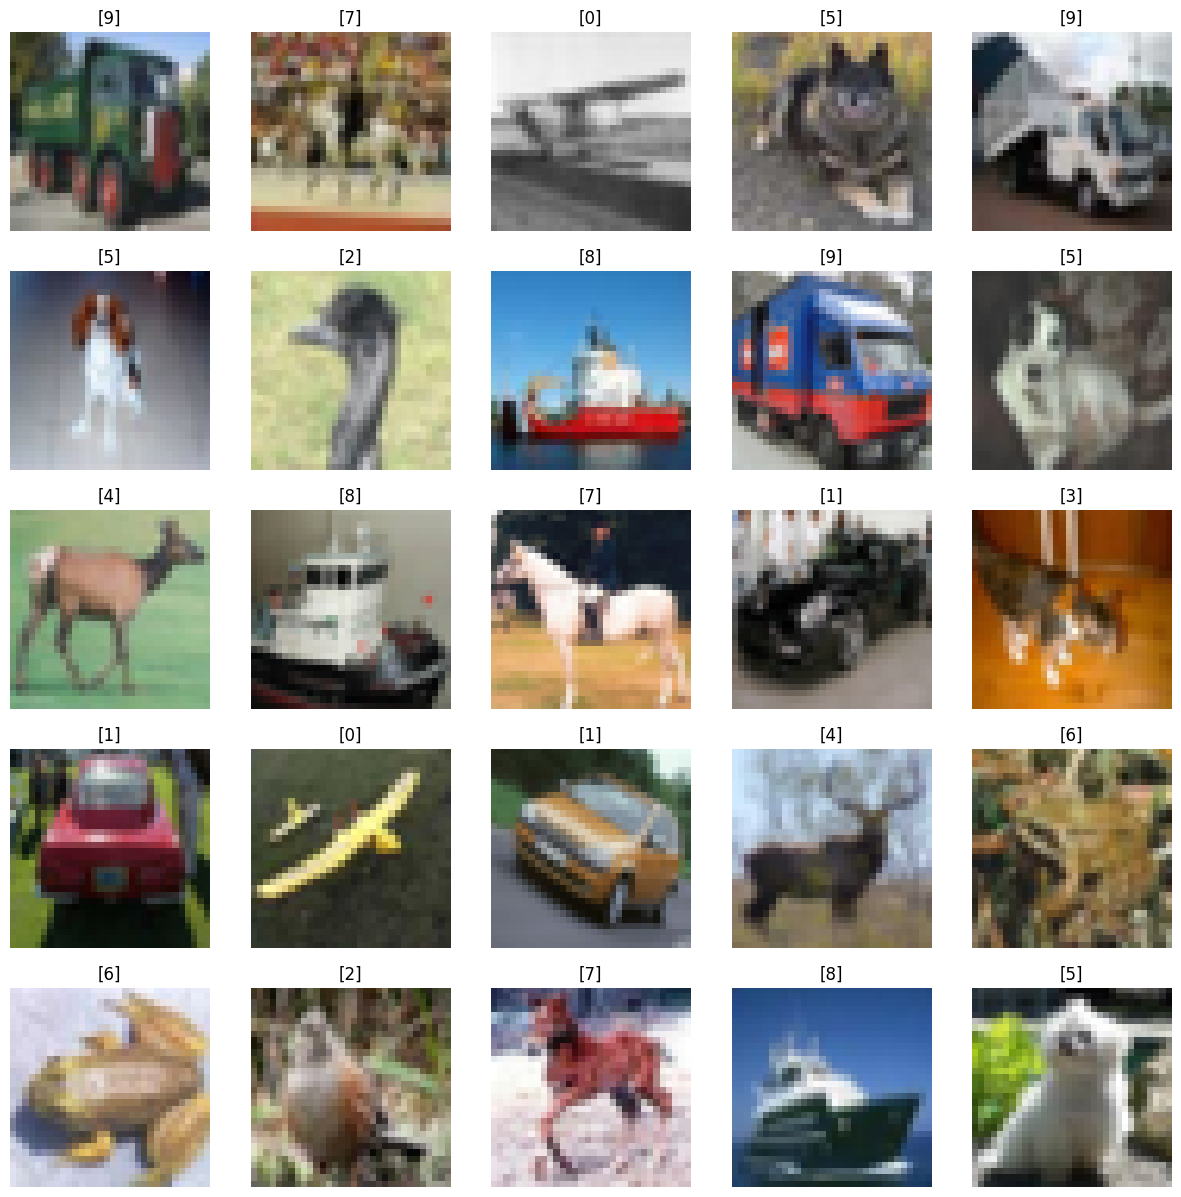

In [ ]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

width=5
height=5
fig,axes =plt.subplots(height,width,figsize=(15,15))
axes=axes.ravel()

for i in np.arange(0,width*height):
    index=np.random.randint(0,49999)
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')

In [ ]:
#Normalize between 0 and 1
X_train =X_train/255
X_test  =X_test/255

X_train.max(),X_train.min()

(np.float64(1.0), np.float64(0.0))

In [ ]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

# Baseline AutoEncoder

In [ ]:



#Encoder

image_input = Input(shape=(32,32,3))

x = Conv2D(64, (3,3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = AveragePooling2D((2,2), padding='same')(x)  # => (4,4,16)


#Decoder

x = UpSampling2D((2,2))(encoded)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_baseline = Model(image_input, decoded)

In [ ]:
autoencoder_baseline.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
autoencoder_baseline.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 8, 8, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 4, 4, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,515 (205.14 KB)

 Trainable params: 52,291 (204.26 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
history_baseline=autoencoder_baseline.fit(X_train, X_train, epochs=50,batch_size=32,validation_data=(X_test, X_test))

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.6549 - loss: 0.5862 - val_accuracy: 0.7405 - val_loss: 0.5683
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7235 - loss: 0.5680 - val_accuracy: 0.6970 - val_loss: 0.5666
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7407 - loss: 0.5647 - val_accuracy: 0.7373 - val_loss: 0.5644
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7455 - loss: 0.5640 - val_accuracy: 0.7528 - val_loss: 0.5633
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7492 - loss: 0.5634 - val_accuracy: 0.7704 - val_loss: 0.5637
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7543 - loss: 0.5627 - val_accuracy: 0.7245 - val_loss: 0.5641
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7566 - loss: 0.5625 - val_accuracy: 0.7733 - val_loss: 0.5621
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7563 - loss: 0.5

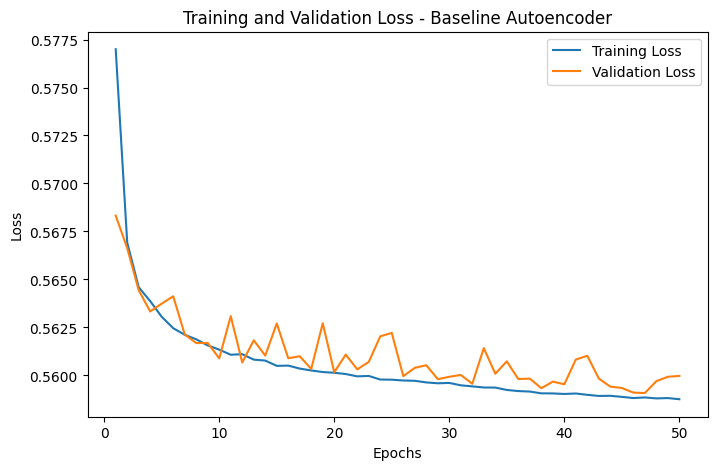

In [ ]:
import matplotlib.pyplot as plt

loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Baseline Autoencoder')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# Create an encoder model
encoder = Model(inputs=autoencoder_baseline.input, outputs=autoencoder_baseline.get_layer('average_pooling2d_2').output)

# Use the encoder model to predict the coded test images
coded_test_images = encoder.predict(X_test)
coded_test_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


(10000, 4, 4, 16)

In [ ]:
decoded_test_images = autoencoder_baseline.predict(X_test)
decoded_test_images.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 99ms/step


(10000, 32, 32, 3)

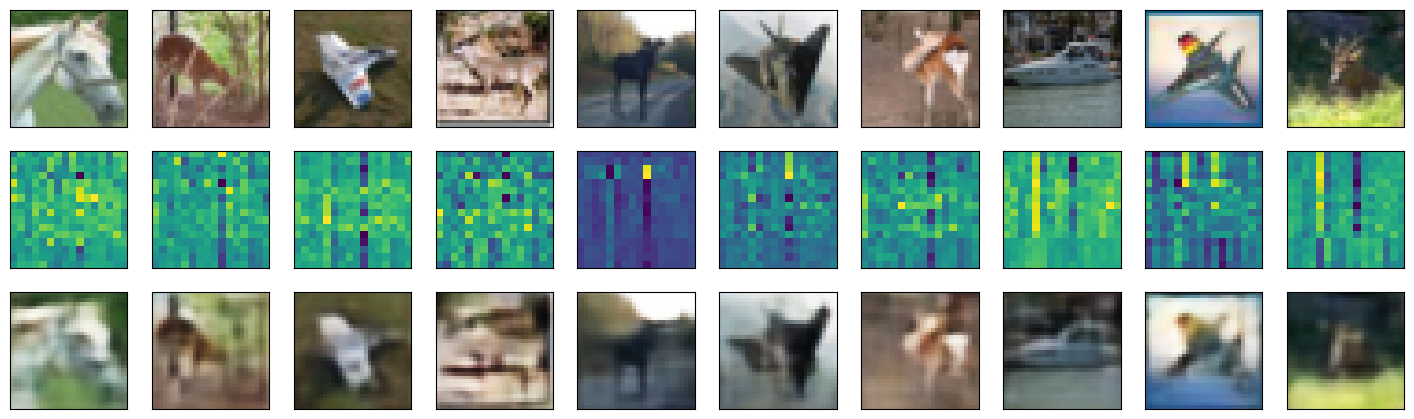

In [ ]:
n_images = 10
test_images = np.random.randint(0, X_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):

  # Original image
  ax = plt.subplot(10,10,i + 1)
  plt.imshow(X_test[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())



  # Coded image
  ax = plt.subplot(10,10,i + 1 + n_images)
  plt.imshow(coded_test_images[image_index].reshape(16,16))
  plt.xticks(())
  plt.yticks(())


  # Decoded image
  ax = plt.subplot(10,10,i + 1 + n_images * 2)
  plt.imshow(decoded_test_images[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())

In [ ]:
autoencoder_baseline.save("/content/drive/MyDrive/models/autoencoder_baseline.keras")

# Labeled AutoEncoder


In [ ]:


y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot  = to_categorical(y_test, num_classes=10)

y_train_onehot.shape, y_test_onehot.shape

((50000, 10), (10000, 10))

In [ ]:


#Encoder

image_input = Input(shape=(32,32,3))

x = Conv2D(64, (3,3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = AveragePooling2D((2,2), padding='same')(x)  # => (4,4,16)

#Side Information : Labels
label_input =Input(shape=(10,))
label_dense=Dense(16,activation="relu")(label_input)
encoded_flat= Flatten()(encoded)
merged= Concatenate()([encoded_flat,label_dense])
x = Dense(4*4*16, activation="relu")(merged)
x = Reshape((4,4,16))(x)


#Decoder

x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_label = Model(inputs=[image_input, label_input], outputs=decoded)

In [ ]:
autoencoder_label.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history_label = autoencoder_label.fit([X_train, y_train_onehot],
                      X_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=([X_test, y_test_onehot], X_test))


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.5344 - loss: 0.6004 - val_accuracy: 0.6350 - val_loss: 0.5841
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6484 - loss: 0.5761 - val_accuracy: 0.7001 - val_loss: 0.5711
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7068 - loss: 0.5710 - val_accuracy: 0.7311 - val_loss: 0.5679
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7192 - loss: 0.5675 - val_accuracy: 0.6437 - val_loss: 0.5668
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7316 - loss: 0.5642 - val_accuracy: 0.7342 - val_loss: 0.5638
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7377 - loss: 0.5631 - val_accuracy: 0.7175 - val_loss: 0.5625
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7475 - loss: 0.5618 - val_accuracy: 0.7563 - val_loss: 0.5623
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7487 - loss: 0

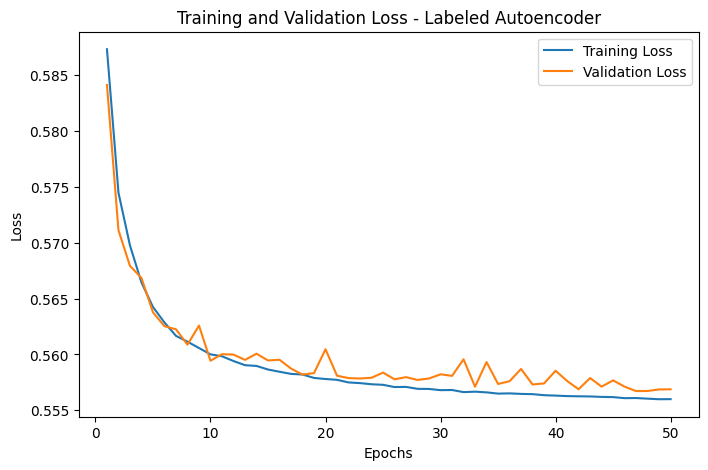

In [ ]:
import matplotlib.pyplot as plt

loss = history_label.history['loss']
val_loss = history_label.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Labeled Autoencoder')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
autoencoder_label.save("/content/drive/MyDrive/models/autoencoder_label.keras")

In [ ]:
decoded_label= autoencoder_label.predict([X_test,y_test_onehot])
encoder_label = Model(inputs=autoencoder_label.input, outputs=autoencoder_label.get_layer('flatten').output)
coded_label = encoder_label.predict([X_test, y_test_onehot])

313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [ ]:
print("Shape coded_label:", coded_label.shape)

Shape coded_label: (10000, 256)


In [ ]:
n_images = 10
test_images = np.random.randint(0, X_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):

  # Original image
  ax = plt.subplot(10,10,i + 1)
  plt.imshow(X_test[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())



  # Coded image
  ax = plt.subplot(10,10,i + 1 + n_images)
  plt.imshow(coded_label[image_index].reshape(16,16))
  plt.xticks(())
  plt.yticks(())


  # Decoded image
  ax = plt.subplot(10,10,i + 1 + n_images * 2)
  plt.imshow(decoded_label[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())

# VisualAttributs AutoEncoder

In [ ]:


def extract_visual_features(image):

    original_image = image.copy()

    if image.max() <= 1.0:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image.astype(np.uint8)

    #HSV Histogram
    hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV)

    h_hist = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [8], [0, 256])

    h_hist = h_hist.flatten() / h_hist.sum()
    s_hist = s_hist.flatten() / s_hist.sum()
    v_hist = v_hist.flatten() / v_hist.sum()

    hsv_features = np.concatenate([h_hist, s_hist, v_hist])

    #RGB statistics
    rgb_stats = []
    for c in range(3):
        channel = original_image[:,:,c].flatten()
        rgb_stats.extend([
            np.mean(channel),
            np.std(channel),
            skew(channel),
            kurtosis(channel)
        ])

    return np.concatenate([hsv_features, rgb_stats])

#Extraction for the train dataset
visual_attrs = []
for i in tqdm(range(len(X_train)), desc="Extracting train features"):
    attrs = extract_visual_features(X_train[i])
    visual_attrs.append(attrs)
visual_attrs = np.array(visual_attrs)

#Normalization
visual_attrs_fixed = visual_attrs.copy()
kurtosis_features = [27, 31, 35]
for feat in kurtosis_features:
    visual_attrs_fixed[:, feat] = np.clip(visual_attrs_fixed[:, feat], -10, 10)


scaler = StandardScaler()
visual_attrs_normalized = scaler.fit_transform(visual_attrs_fixed)


Extracting train features: 100%|██████████| 50000/50000 [04:19<00:00, 192.72it/s]


In [ ]:
visual_attrs_normalized.shape

(50000, 36)

In [ ]:
# Extraction for the test dataset
visual_attrs_test = []
for i in tqdm(range(len(X_test)), desc="Extracting test features"):
    attrs = extract_visual_features(X_test[i])
    visual_attrs_test.append(attrs)
visual_attrs_test = np.array(visual_attrs_test)

#Normalization
visual_attrs_test_fixed = visual_attrs_test.copy()
for feat in kurtosis_features:
    visual_attrs_test_fixed[:, feat] = np.clip(visual_attrs_test_fixed[:, feat], -10, 10)
visual_attrs_test_normalized = scaler.transform(visual_attrs_test_fixed)

Extracting test features: 100%|██████████| 10000/10000 [00:48<00:00, 204.53it/s]


In [ ]:


# Encoder
image_input = Input(shape=(32,32,3))

x = Conv2D(64, (3,3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D((2,2), padding='same')(x)

x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = AveragePooling2D((2,2), padding='same')(x)  # => (4,4,16)

# Side Information : Visuals Attributs
visual_attr_input = Input(shape=(36,))  # HSV(24) + RGB stats(12)
attr_dense = Dense(32, activation="relu")(visual_attr_input)
attr_dense = Dense(16, activation="relu")(attr_dense)

encoded_visual = Flatten()(encoded)
merged = Concatenate()([encoded_visual, attr_dense])

x = Dense(4*4*16, activation="relu")(merged)
x = Reshape((4,4,16))(x)

# Decoder
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

decoded_visual = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)


autoencoder_visual = Model([image_input, visual_attr_input], decoded_visual)

In [ ]:
autoencoder_visual.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history_fit = autoencoder_visual.fit([X_train, visual_attrs_normalized], X_train, epochs=50,batch_size=32,
    validation_data=([X_test, visual_attrs_test_normalized], X_test))

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5321 - loss: 0.6001 - val_accuracy: 0.6751 - val_loss: 0.5751
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6924 - loss: 0.5727 - val_accuracy: 0.7481 - val_loss: 0.5691
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7391 - loss: 0.5674 - val_accuracy: 0.7663 - val_loss: 0.5666
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7487 - loss: 0.5629 - val_accuracy: 0.7652 - val_loss: 0.5620
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7607 - loss: 0.5619 - val_accuracy: 0.7542 - val_loss: 0.5618
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7670 - loss: 0.5608 - val_accuracy: 0.7770 - val_loss: 0.5610
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7706 - loss: 0.5602 - val_accuracy: 0.7761 - val_loss: 0.5596
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7731 - loss: 

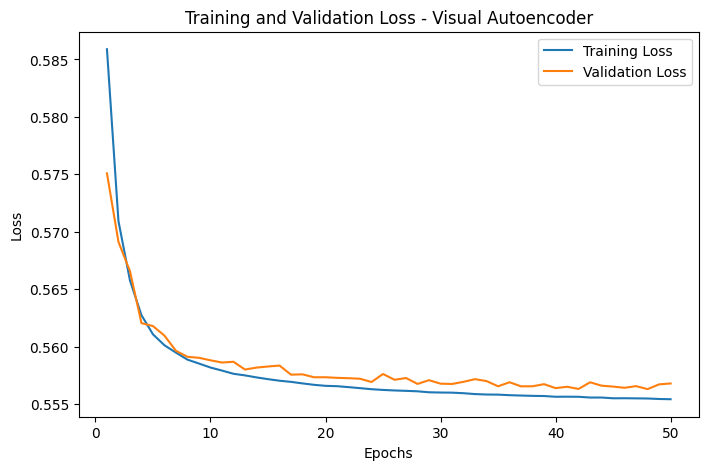

In [ ]:
import matplotlib.pyplot as plt

loss = history_fit.history['loss']
val_loss = history_fit.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Visual Autoencoder')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
autoencoder_visual.save("/content/drive/MyDrive/models/autoencoder_visual.keras")

In [ ]:

decoded_visual = autoencoder_visual.predict([X_test, visual_attrs_test_normalized])

encoder_visual = Model(inputs=autoencoder_visual.input, outputs=autoencoder_visual.get_layer('flatten_1').output)
coded_visual = encoder_visual.predict([X_test, visual_attrs_test_normalized])

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


In [ ]:
n_images = 10
test_images = np.random.randint(0, X_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):

  # Original image
  ax = plt.subplot(10,10,i + 1)
  plt.imshow(X_test[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())



  # Coded image
  ax = plt.subplot(10,10,i + 1 + n_images)
  plt.imshow(coded_visual[image_index].reshape(16,16))
  plt.xticks(())
  plt.yticks(())


  # Decoded image
  ax = plt.subplot(10,10,i + 1 + n_images * 2)
  plt.imshow(decoded_visual[image_index].reshape(32,32,3))
  plt.xticks(())
  plt.yticks(())

# Load the models

In [ ]:
autoencoder_baseline = keras.models.load_model("/content/drive/MyDrive/models/autoencoder_baseline.keras")
autoencoder_label = keras.models.load_model("/content/drive/MyDrive/models/autoencoder_label.keras")
autoencoder_visual = keras.models.load_model("/content/drive/MyDrive/models/autoencoder_visual.keras")

# Metrics


In [ ]:
def calculate_mse(original, reconstructed):
    mse_list=[]
    for i in range(original.shape[0]):
        mse_list.append(np.mean(np.square(original[i]-reconstructed[i])))
    return np.mean(mse_list)

mse_list = [calculate_mse(X_test, decoded_test_images)]
mse_avg = np.mean(mse_list)
print("MSE for AE without side information:", mse_avg)

mse_list_label = [calculate_mse(X_test, decoded_label)]
mse_avg_label = np.mean(mse_list_label)
print("MSE for AE with label side information:", mse_avg_label)

mse_list_visual = [calculate_mse(X_test, decoded_visual)]
mse_avg_visual = np.mean(mse_list_visual)
print("MSE for AE with visuals attributs side information:", mse_avg_visual)





MSE for AE without side information: 0.004777634541209579
MSE for AE with label side information: 0.0035594951422663677
MSE for AE with visuals attributs side information: 0.0031905337403442375


In [ ]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100
    max_pixel_value = 1.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

psnr_list_visual = [calculate_psnr(X_test[i], decoded_visual[i]) for i in range(X_test.shape[0])]
psnr_avg_visual = np.mean(psnr_list_visual)
print("PSNR Visual moyen:", psnr_avg_visual)

psnr_list_label = [calculate_psnr(X_test[i], decoded_label[i]) for i in range(X_test.shape[0])]
psnr_avg_label = np.mean(psnr_list_label)
print("PSNR Label moyen:", psnr_avg_label)

psnr_list = [calculate_psnr(X_test[i], decoded_test_images[i]) for i in range(X_test.shape[0])]
psnr_avg = np.mean(psnr_list)
print("PSNR moyen:", psnr_avg)

PSNR Visual moyen: 25.571544171871867
PSNR Label moyen: 25.03020448513318
PSNR moyen: 23.713350087657517


In [ ]:

def calculate_ssim(original, reconstructed):
  ssim_list=[]
  for i in range(original.shape[0]):


    ssim_r = ssim(original[i][:,:,0], reconstructed[i][:,:,0], data_range=1)
    ssim_g = ssim(original[i][:,:,1], reconstructed[i][:,:,1], data_range=1)
    ssim_b = ssim(original[i][:,:,2], reconstructed[i][:,:,2], data_range=1)
    ssim_list.append(np.mean([ssim_r, ssim_g, ssim_b]))
  ssim_avg = np.mean(ssim_list)
  return ssim_avg


ssim_list_visual = [calculate_ssim(X_test, decoded_visual)]
ssim_avg_visual = np.mean(ssim_list_visual)
print("SSIM Visual moyen:", ssim_avg_visual)

ssim_list_label = [calculate_ssim(X_test, decoded_label)]
ssim_avg_label = np.mean(ssim_list_label)
print("SSIM Label moyen:", ssim_avg_label)

ssim_list = [calculate_ssim(X_test, decoded_test_images)]
ssim_avg = np.mean(ssim_list)
print("SSIM moyen:", ssim_avg)

SSIM Visual moyen: 0.8640022284165125
SSIM Label moyen: 0.8494879542102274
SSIM moyen: 0.8137032616262443


# Results


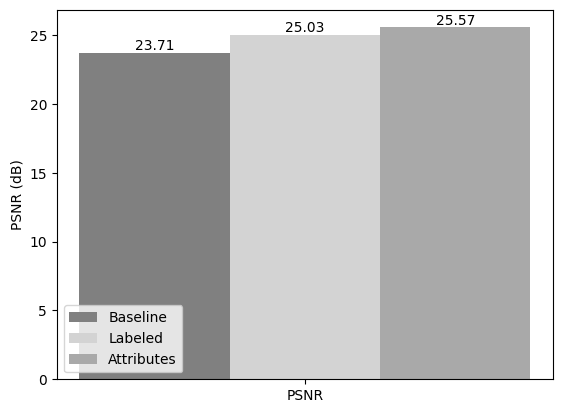

In [ ]:
metrics = ["PSNR"]
baseline_values = [psnr_avg]
labeled_values  = [psnr_avg_label]
attrib_values   = [psnr_avg_visual]

x = np.arange(len(metrics))
width = 0.25

bars1 = plt.bar(x - width, baseline_values, width, label="Baseline", color="gray")
bars2 = plt.bar(x, labeled_values, width, label="Labeled", color="lightgray")
bars3 = plt.bar(x + width, attrib_values, width, label="Attributes", color="darkgray")

plt.xticks(x, metrics)
plt.ylabel("PSNR (dB)")
plt.legend()


for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

plt.show()



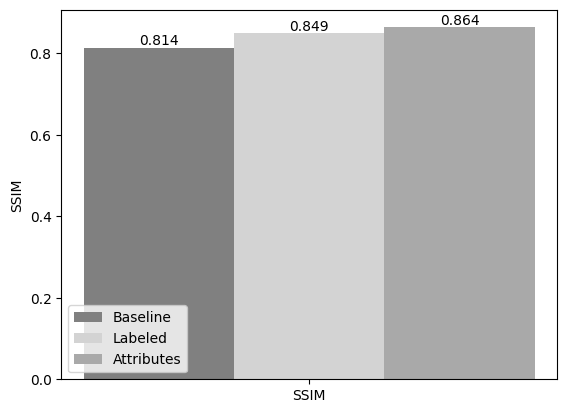

In [ ]:
metrics = ["SSIM"]
baseline_values = [ssim_avg]
labeled_values  = [ssim_avg_label]
attrib_values   = [ssim_avg_visual]

x = np.arange(len(metrics))
width = 0.25

bars1 = plt.bar(x - width, baseline_values, width, label="Baseline", color="gray")
bars2 = plt.bar(x, labeled_values, width, label="Labeled", color="lightgray")
bars3 = plt.bar(x + width, attrib_values, width, label="Attributes", color="darkgray")

plt.xticks(x, metrics)
plt.ylabel("SSIM")
plt.legend()


for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')  # 3 décimales pour SSIM

plt.show()


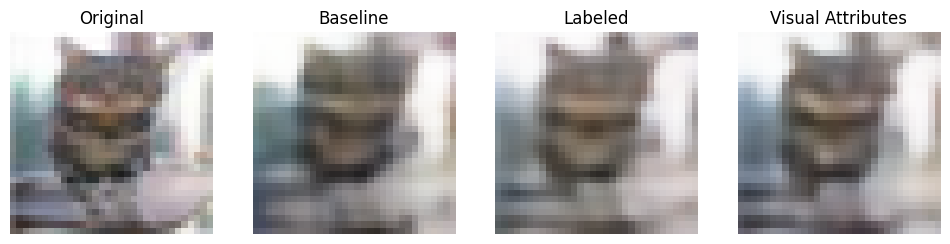

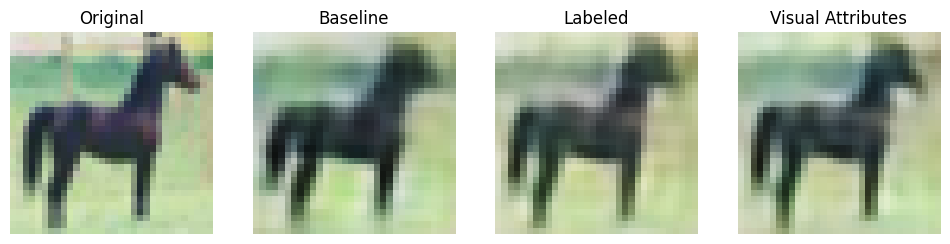

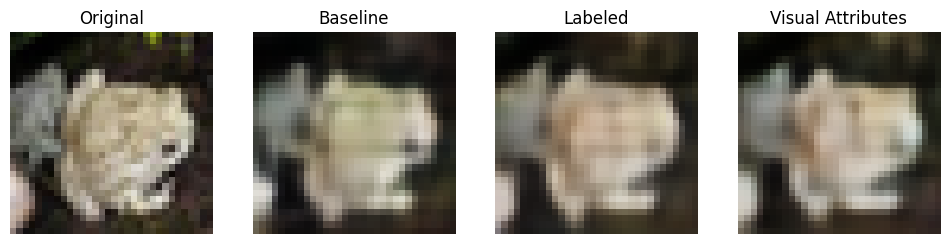

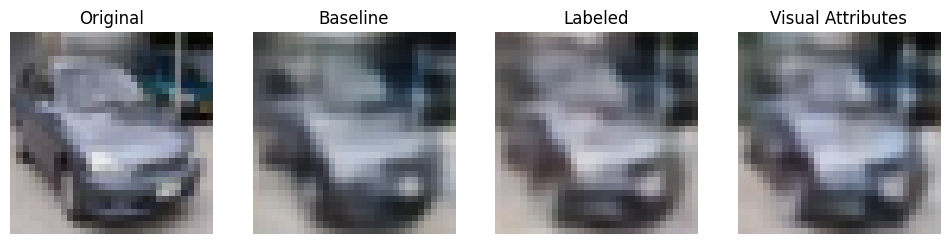

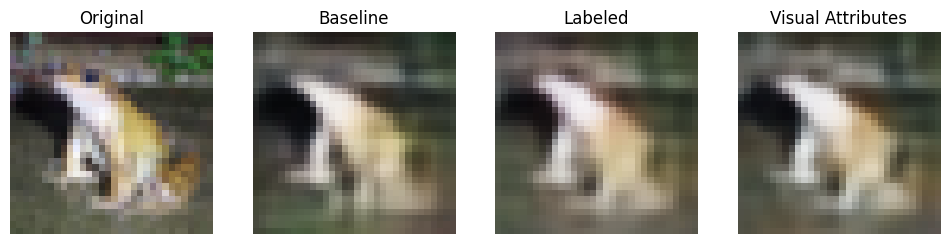

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


n_examples = 5


indices = np.random.choice(X_test.shape[0], n_examples, replace=False)


for idx in indices:
    fig, axes = plt.subplots(1, 4, figsize=(12,3))

    # Originale
    axes[0].imshow(X_test[idx])
    axes[0].set_title("Original")

    # Baseline AE
    axes[1].imshow(decoded_test_images[idx])
    axes[1].set_title("Baseline")

    # Labeled AE
    axes[2].imshow(decoded_label[idx])
    axes[2].set_title("Labeled")

    # Attributes AE
    axes[3].imshow(decoded_visual[idx])
    axes[3].set_title("Visual Attributes")

    for ax in axes:
        ax.axis("off")
    plt.show()


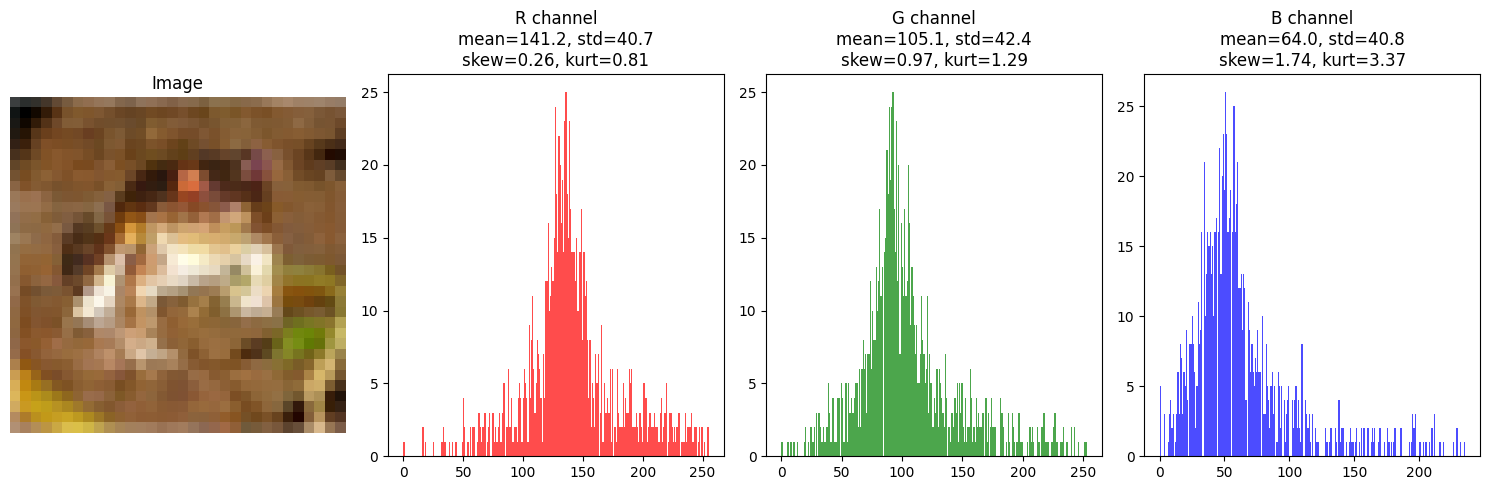

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def visualize_rgb_stats(image):

    if image.max() <= 1.0:
        img = (image * 255).astype(np.uint8)
    else:
        img = image.astype(np.uint8)

    colors = ['R', 'G', 'B']

    plt.figure(figsize=(15,5))


    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')


    for i, c in enumerate(colors):
        channel = img[:,:,i].flatten()
        plt.subplot(1,4,i+2)
        plt.hist(channel, bins=256, color=c.lower(), alpha=0.7)
        mu = np.mean(channel)
        sigma = np.std(channel)
        sk = skew(channel)
        kt = kurtosis(channel)
        plt.title(f"{c} channel\nmean={mu:.1f}, std={sigma:.1f}\nskew={sk:.2f}, kurt={kt:.2f}")

    plt.tight_layout()
    plt.show()


visualize_rgb_stats(X_train[0])


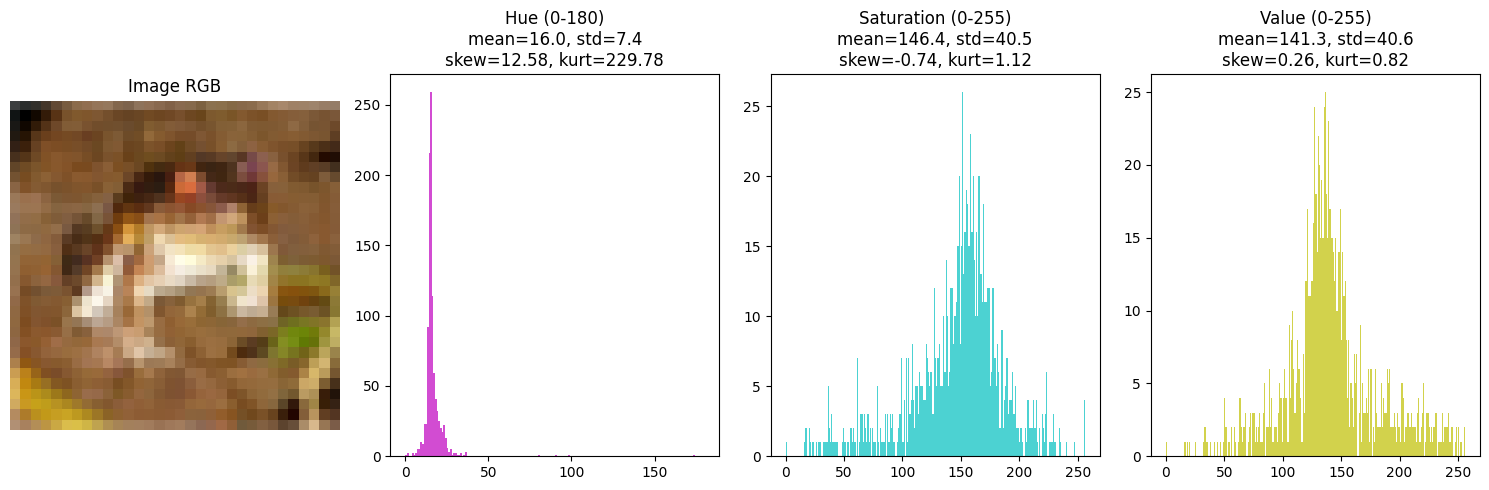

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import cv2
import numpy as np

def visualize_hsv_stats(image):

    if image.max() <= 1.0:
        img = (image * 255).astype(np.uint8)
    else:
        img = image.astype(np.uint8)


    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    channels = ['Hue (0-180)', 'Saturation (0-255)', 'Value (0-255)']
    colors = ['m', 'c', 'y']  # juste pour différencier visuellement

    plt.figure(figsize=(15,5))


    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image RGB")
    plt.axis('off')


    for i, name in enumerate(channels):
        channel = hsv[:,:,i].flatten()
        plt.subplot(1,4,i+2)
        if i == 0:
            bins = 180
            range_vals = (0,180)
        else:
            bins = 256
            range_vals = (0,256)
        plt.hist(channel, bins=bins, color=colors[i], alpha=0.7, range=range_vals)

        mu = np.mean(channel)
        sigma = np.std(channel)
        sk = skew(channel)
        kt = kurtosis(channel)

        plt.title(f"{name}\nmean={mu:.1f}, std={sigma:.1f}\nskew={sk:.2f}, kurt={kt:.2f}")

    plt.tight_layout()
    plt.show()


visualize_hsv_stats(X_train[0])


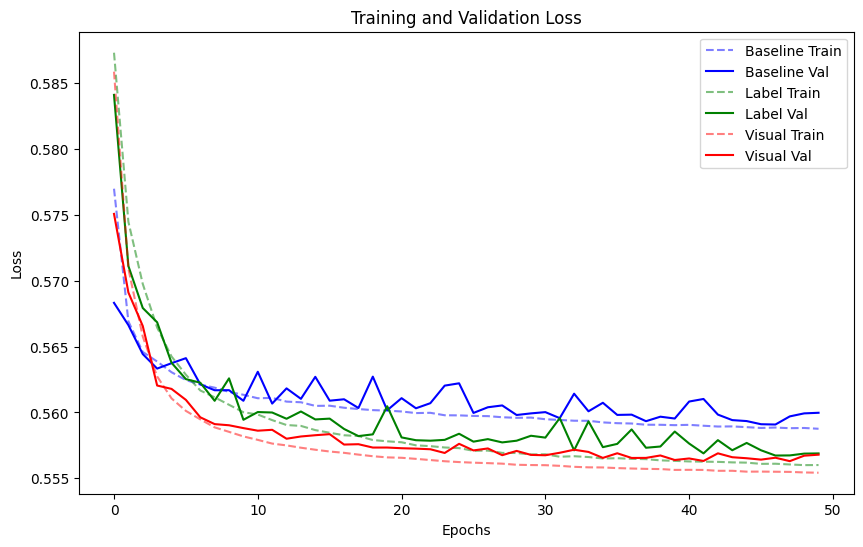

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Baseline
plt.plot(history_baseline.history['loss'], '--', color='blue', alpha=0.5, label='Baseline Train')
plt.plot(history_baseline.history['val_loss'], '-', color='blue', label='Baseline Val')

# Label Side Info
plt.plot(history_label.history['loss'], '--', color='green', alpha=0.5, label='Label Train')
plt.plot(history_label.history['val_loss'], '-', color='green', label='Label Val')

# Visual Side Info
plt.plot(history_fit.history['loss'], '--', color='red', alpha=0.5, label='Visual Train')
plt.plot(history_fit.history['val_loss'], '-', color='red', label='Visual Val')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.show()
